## Set main parameters

In [63]:
ROOT = "/home/STual/DAN-cadastre"

### Display example of data

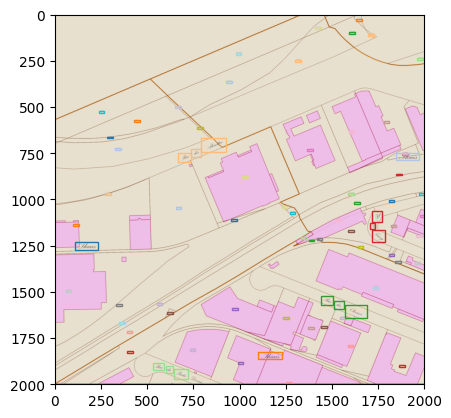

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as MplPolygon
import matplotlib.image as mpimg

# Read the CSV file
path = f"{ROOT}/dataset-cartes/synth_maps_dataset/sortie/"
csv_file = f"{ROOT}/dataset-cartes/annotations.csv"
df = pd.read_csv(csv_file)

# Function to parse WKT points and convert them to a list of coordinates
def parse_wkt_point(wkt):
    wkt = wkt.replace('POINT(', '').replace(')', '')
    wkt = wkt.split(' ')
    coords = list(map(float, wkt))
    return coords

zoneid = "zone_0_3"
# Image dimensions (adjust these to match your image)
image_path = path + 'extrait_' + zoneid +'.png'
img = mpimg.imread(image_path)
img_height, img_width, _ = img.shape

# Create a plot
fig, ax = plt.subplots()
ax.imshow(img)

# Dictionary to store colors for each 'cle_origine'
color_dict = {}

# Convert the DataFrame to polygons and plot them
for _, row in df.iterrows():
    if row['id_zone'] == zoneid:  # Filter by id_zone
        xmin_ymin = parse_wkt_point(row['xmin_ymin'])
        xmin_ymax = parse_wkt_point(row['xmin_ymax'])
        xmax_ymax = parse_wkt_point(row['xmax_ymax'])
        xmax_ymin = parse_wkt_point(row['xmax_ymin'])
        
        # Create the polygon coordinates
        coordinates = [xmin_ymin, xmin_ymax, xmax_ymax, xmax_ymin, xmin_ymin]
        
        # Create a polygon
        polygon = Polygon(coordinates)
        
        # Generate a color for each 'cle_origine' if not already in the dictionary
        if row['cle_origine'] not in color_dict:
            color_dict[row['cle_origine']] = plt.cm.tab20(len(color_dict) % 20)
        
        # Create a matplotlib polygon patch
        mpl_polygon = MplPolygon(list(polygon.exterior.coords), closed=True, 
                                 edgecolor=color_dict[row['cle_origine']], fill=False)
        
        # Add the patch to the plot
        ax.add_patch(mpl_polygon)

# Set plot limits to image dimensions
ax.set_xlim(0, img_width)
ax.set_ylim(img_height, 0)  # Flip the y-axis to match image coordinates

plt.show()


### Create subsets and format named entities

In [55]:
import random
from typing import List, Tuple
import glob
import os

def split_dataset(data: List[str], train_ratio: float, val_ratio: float, test_ratio: float, seed: int = None) -> Tuple[List[str], List[str], List[str]]:
    """
    Splits the dataset into train, validation, and test sets based on the given ratios.

    Args:
        data (List[str]): List of data samples (e.g., file paths).
        train_ratio (float): Proportion of data to use for the training set.
        val_ratio (float): Proportion of data to use for the validation set.
        test_ratio (float): Proportion of data to use for the test set.
        seed (int, optional): Random seed for reproducibility. Defaults to None.

    Returns:
        Tuple[List[str], List[str], List[str]]: A tuple containing the train, validation, and test sets.
    """
    if seed is not None:
        random.seed(seed)

    # Ensure the ratios sum to 1.0
    assert train_ratio + val_ratio + test_ratio == 1.0, "Train, validation, and test ratios must sum to 1.0"

    # Shuffle the data
    random.shuffle(data)

    # Calculate split indices
    total = len(data)
    train_end = int(train_ratio * total)
    val_end = train_end + int(val_ratio * total)

    # Split the data
    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    return train_data, val_data, test_data


# Example usage
data_samples = glob.glob(os.path.join(path, '*.png'))
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2
seed = 42

train_data, val_data, test_data = split_dataset(data_samples, train_ratio, val_ratio, test_ratio, seed)

print("Train Data:", train_data)
print("Validation Data:", val_data)
print("Test Data:", test_data)
subsets = {'train': train_data, 'val': val_data, 'test': test_data}

Train Data: ['/home/STual/DAN-cadastre/dataset-cartes/synth_maps_dataset/sortie/extrait_zone_8_0.png', '/home/STual/DAN-cadastre/dataset-cartes/synth_maps_dataset/sortie/extrait_zone_4_9.png', '/home/STual/DAN-cadastre/dataset-cartes/synth_maps_dataset/sortie/extrait_zone_2_2.png', '/home/STual/DAN-cadastre/dataset-cartes/synth_maps_dataset/sortie/extrait_zone_5_9.png', '/home/STual/DAN-cadastre/dataset-cartes/synth_maps_dataset/sortie/extrait_zone_6_9.png', '/home/STual/DAN-cadastre/dataset-cartes/synth_maps_dataset/sortie/extrait_zone_3_1.png', '/home/STual/DAN-cadastre/dataset-cartes/synth_maps_dataset/sortie/extrait_zone_2_1.png', '/home/STual/DAN-cadastre/dataset-cartes/synth_maps_dataset/sortie/extrait_zone_2_8.png', '/home/STual/DAN-cadastre/dataset-cartes/synth_maps_dataset/sortie/extrait_zone_6_1.png', '/home/STual/DAN-cadastre/dataset-cartes/synth_maps_dataset/sortie/extrait_zone_5_3.png', '/home/STual/DAN-cadastre/dataset-cartes/synth_maps_dataset/sortie/extrait_zone_3_9.png

In [56]:
#using annotations.csv, can you concatenate the "texte" that have the same id zone. For each "texte", depending on the "nature" value, add the following tokens before and after the words
#tokens => parcelle: start: Ⓐ end: Ⓑ
        #=>nature: start: Ⓒ end: Ⓓ

# Create a dictionary to store the concatenated text for each id_zone
concatenated_text = {}

# Iterate over the DataFrame
for _, row in df.iterrows():
    if row['id_zone'] in concatenated_text:
        concatenated_text[row['id_zone']] += ' '
        if row['nature'] == 'parcelle':
            concatenated_text[row['id_zone']] += 'Ⓐ' + row['texte'] + 'Ⓑ'
        elif row['nature'] == 'nature':
            concatenated_text[row['id_zone']] += 'Ⓒ' + row['texte'] + 'Ⓓ'
    else:
        if row['nature'] == 'parcelle':
            concatenated_text[row['id_zone']] = 'Ⓐ' + row['texte'] + 'Ⓑ'
        elif row['nature'] == 'nature':
            concatenated_text[row['id_zone']] = 'Ⓒ' + row['texte'] + 'Ⓓ'

In [57]:
concatenated_text

{'zone_0_0': 'Ⓐ0021Ⓑ Ⓐ0056Ⓑ Ⓐ0059Ⓑ     ',
 'zone_0_1': 'Ⓐ0115Ⓑ Ⓐ0052Ⓑ Ⓐ0001Ⓑ Ⓐ0010Ⓑ Ⓐ0011Ⓑ Ⓐ0113Ⓑ Ⓐ0114Ⓑ Ⓐ0115Ⓑ Ⓐ0116Ⓑ Ⓐ0117Ⓑ Ⓐ0012Ⓑ Ⓐ0124Ⓑ Ⓐ0013Ⓑ Ⓐ0014Ⓑ Ⓐ0142Ⓑ Ⓐ0015Ⓑ Ⓐ0172Ⓑ Ⓐ0175Ⓑ Ⓐ0179Ⓑ Ⓐ0182Ⓑ Ⓐ0185Ⓑ Ⓐ0188Ⓑ Ⓐ0189Ⓑ Ⓐ0002Ⓑ Ⓐ0230Ⓑ Ⓐ0233Ⓑ Ⓐ0234Ⓑ Ⓐ0235Ⓑ Ⓐ0236Ⓑ Ⓐ0237Ⓑ Ⓐ0238Ⓑ Ⓐ0239Ⓑ Ⓐ0240Ⓑ Ⓐ0241Ⓑ Ⓐ0242Ⓑ Ⓐ0243Ⓑ Ⓐ0244Ⓑ Ⓐ0245Ⓑ Ⓐ0003Ⓑ Ⓐ0035Ⓑ Ⓐ0036Ⓑ Ⓐ0037Ⓑ Ⓐ0038Ⓑ Ⓐ0039Ⓑ Ⓐ0004Ⓑ Ⓐ0040Ⓑ Ⓐ0045Ⓑ Ⓐ0046Ⓑ Ⓐ0047Ⓑ Ⓐ0005Ⓑ Ⓐ0006Ⓑ Ⓐ0061Ⓑ Ⓐ0062Ⓑ Ⓐ0007Ⓑ Ⓐ0008Ⓑ Ⓐ0009Ⓑ        ',
 'zone_0_2': 'Ⓐ0043Ⓑ Ⓐ0110Ⓑ Ⓐ0111Ⓑ Ⓐ0112Ⓑ Ⓐ0121Ⓑ Ⓐ0125Ⓑ Ⓐ0013Ⓑ Ⓐ0156Ⓑ Ⓐ0157Ⓑ Ⓐ0159Ⓑ Ⓐ0160Ⓑ Ⓐ0161Ⓑ Ⓐ0162Ⓑ Ⓐ0163Ⓑ Ⓐ0164Ⓑ Ⓐ0165Ⓑ Ⓐ0166Ⓑ Ⓐ0167Ⓑ Ⓐ0168Ⓑ Ⓐ0169Ⓑ Ⓐ0177Ⓑ Ⓐ0178Ⓑ Ⓐ0179Ⓑ Ⓐ0180Ⓑ Ⓐ0181Ⓑ Ⓐ0182Ⓑ Ⓐ0183Ⓑ Ⓐ0184Ⓑ Ⓐ0186Ⓑ Ⓐ0187Ⓑ Ⓐ0190Ⓑ Ⓐ0002Ⓑ Ⓐ0217Ⓑ Ⓐ0218Ⓑ Ⓐ0022Ⓑ Ⓐ0221Ⓑ Ⓐ0222Ⓑ Ⓐ0226Ⓑ Ⓐ0229Ⓑ Ⓐ0242Ⓑ Ⓐ0245Ⓑ Ⓐ0246Ⓑ Ⓐ0256Ⓑ Ⓐ0260Ⓑ Ⓐ0261Ⓑ Ⓐ0262Ⓑ Ⓐ0263Ⓑ Ⓐ0269Ⓑ Ⓐ0271Ⓑ Ⓐ0272Ⓑ Ⓐ0273Ⓑ Ⓐ0274Ⓑ Ⓐ0275Ⓑ Ⓐ0285Ⓑ Ⓐ0286Ⓑ Ⓐ0311Ⓑ Ⓐ0312Ⓑ Ⓐ0313Ⓑ Ⓐ0034Ⓑ Ⓐ0375Ⓑ Ⓐ0038Ⓑ Ⓐ0038Ⓑ Ⓐ0039Ⓑ Ⓐ0004Ⓑ Ⓐ0043Ⓑ Ⓐ0047Ⓑ Ⓐ0048Ⓑ Ⓐ0049Ⓑ Ⓐ0005Ⓑ Ⓐ0006Ⓑ Ⓐ0097Ⓑ                ',
 'zone_0_3': 

### Create split.json

In [58]:
import re

splitjson = { "test" : {},
"val" : {},
"train" : {}
}

for subset in subsets:
    set_ = subset
    dataset = subsets[subset]

    for elem in dataset:
        fpath = elem.split("/")[-1]
        #use this regex _(.*).png with re lib
        pattern = re.compile(r'_(.*)\.png')
        match = pattern.search(fpath)
        id = match.group(1)
        subjson = {id:{"dataset_id":"synth_maps_dataset","image":{},"text":{}}}
        subjson[id]["image"]["iiif_url"] = elem
        subjson[id]["image"]["polygon"] = [
                    [0,0],
                    [0,2000],
                    [2000,2000],
                    [2000,0],[0,0]
                ]
        subjson[id]["text"] = concatenated_text[id]
        splitjson[set_].update(subjson)

In [59]:
#write finaljson as split.json file
import json
with open(f"{ROOT}/dataset-cartes/synth_maps_dataset/split.json", 'w') as f:
    json.dump(splitjson, f, indent=4)
    

### Create labels.json

In [60]:
#using the train_data, val_data and test_data, can you create a new folder for each subset, that contains a synth_maps_dataset folder, and copy the images in this last corresponding folder
import shutil
for subset in subsets:
    
    dataset = subsets[subset]
    for elem in dataset:
        fpath = elem.split("/")[-1]
        #use this regex _(.*).png with re lib
        pattern = re.compile(r'_(.*)\.png')
        match = pattern.search(fpath)
        id = match.group(1)
        os.makedirs(f"{ROOT}/dataset-cartes/synth_maps_dataset/images/{subset}", exist_ok=True)
        os.makedirs(f"{ROOT}/dataset-cartes/synth_maps_dataset/images/{subset}/synth_maps_dataset", exist_ok=True)
        shutil.copy(elem, f"{ROOT}/dataset-cartes/synth_maps_dataset/images/{subset}/synth_maps_dataset/"+fpath)

In [61]:
labelsjson = { "test" : {},
"val" : {},
"train" : {}
}

for subset in subsets:
    set_ = subset
    dataset = subsets[subset]
    for elem in dataset:
        subjson = {}
        fpath = elem.split("/")[-1]
        #use this regex _(.*).png with re lib
        pattern = re.compile(r'_(.*)\.png')
        match = pattern.search(fpath)
        id = match.group(1)
        url = f"images/{set_}/synth_maps_dataset/extrait_{id}.png"
        subjson[url] = concatenated_text[id]
        labelsjson[set_].update(subjson)

In [62]:
#write finaljson as split.json file
import json
with open(f'{ROOT}/dataset-cartes/synth_maps_dataset/labels.json', 'w') as f:
    json.dump(labelsjson, f, indent=4)

### Create charset.pkl file

In [69]:
#Open the labels.json file and create a new file named charset.pkl that contains the characters used in the text field of the labels.json file
import pickle
import json
with open(f'{ROOT}/dataset-cartes/synth_maps_dataset/labels.json', 'r') as f:
    data = json.load(f)
    text = ""
    for key in data:
        for k in data[key]:
            text += data[key][k]
    charset = set(text)
    with open(f'{ROOT}/dataset-cartes/synth_maps_dataset/charset.pkl', 'wb') as f:
        pickle.dump(charset, f)

### Get some statistics about DAN (help tot set config.json)

In [ ]:
!teklia-dan dataset analyze \
    --labels /home/STual/DAN-cadastre/dataset-cartes/synth_maps_dataset/labels.json \
    --tokens /home/STual/DAN-cadastre/dataset-cartes/tokens.yml \
    --output-file /home/STual/DAN-cadastre/dataset-cartes/statistics.md